### Applying gravity trade model for bilateral trade between Czech Respublic and Kenya

The gravity trade model was described in 1962 [1]. Since then it has been used in different implementations for describing and predicting the value of bilateral trade between different countries. See also [2].

CEPII archive was used as dataset for training models. Link:http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np



from sklearn.model_selection import train_test_split as tts


from sklearn.tree import DecisionTreeRegressor as DTR
%pylab inline


pd.options.mode.chained_assignment = None # Made it for simplifying output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 1000)


Populating the interactive namespace from numpy and matplotlib


## Defining new functions

Implementation of Minkowski distance, Mean Squared Error and Mean Absolute Error for two array.

Also define R-squared score

In [3]:
def Mink(arr1, arr2, n): 
    return np.sum(np.abs(arr1 - arr2) ** n) ** (1/n)

In [4]:
def mean_squared_error(arr1, arr2):
    return 1/len(arr1) * np.sum((arr1-arr2)**2)

In [5]:
def mean_absolute_error(arr1, arr2):
    return 1/len(arr1) * np.sum(np.abs(arr1-arr2))

In [6]:
def r2_score(y, y_pred):
    return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

# Models implementation

### Linear Regression model

In [7]:
class LinearRegression:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        self.w = np.linalg.inv(self.X.T @ self.X) @ (self.X.T @ self.y)
        
    def predict(self, X):
        self.pred = np.array(X) @ self.w
    
    def train_MSE(self):
        return mean_squared_error(np.array(self.X) @ self.w, self.y)
    
    def test_MSE(self, y):
        return mean_squared_error(self.pred, y)
    
    def r2_score(self):
        return r2_score(self.y, np.array(self.X) @ self.w)
    
    def show_coef(self):
        return self.w
    
    def show_predict(self):
        return self.pred

## KNN Implementation

In [8]:
class MyKNN:
    def __init__(self, metric="euclid"):
        if metric not in ['euclid', 'Manhattan', 'Minkowski']:
            raise ValueError('Choose correct metric from euclid, Manhattan')
        self.method = metric
        
    def fit(self, X_tr, y_tr):
        self.data = np.array(X_tr)
        self.resp = np.array(y_tr)

    def predict(self, X_te, n_neigh = 1, n_mink = 2): # Choose the number of neighbours
        if self.method == 'euclid':
            response = np.argsort(np.abs(np.sum((self.data[np.newaxis, :] - np.array(X_te)[:, np.newaxis])**2, axis =2))**0.5, axis = 1)[:, :n_neigh]
        if self.method == 'Manhattan':
            response = np.argsort(np.abs(np.sum((self.data[np.newaxis, :] - np.array(X_te)[:, np.newaxis]), axis =2)), axis = 1)[:, :n_neigh]
        if self.method == 'Minkowski':
            response = np.argsort(np.abs(np.sum((self.data[np.newaxis, :] - np.array(X_te)[:, np.newaxis])**n_mink, axis =2))**(1/n_mink), axis = 1)[:, :n_neigh]
        self.prediction = np.mean(self.resp[response], axis = 1)
        return self.prediction
    
    def r2_score(self):
        return r2_score(self.resp, self.prediction)

## Decision Tree

First and foremost, defining functions of criterion (here is MSE implementation), spliting, recursive spliting and tree itself.
The author is greatful to Jason Brownlee, whose tutorial was very usefull for implemeting the algorithm. Link: https://machinelearningmastery.com/

In [9]:
# Computing the difference in variations between initial array and its right and left parts
def split_var(arr1, arr2):
    total_len = len(np.append(arr1, arr2))
    total_var = np.var(np.append(arr1, arr2))
    return total_var - len(arr1)/total_len * np.var(arr1) - len(arr2) / total_len * np.var(arr2)

# Making a split of data into two parts by given index and threshold
def spliting(data, index, threshold):
    left, right = [], []
    for row in data:
        if row[index] < threshold:
            left += [row]
        else:
            right += [row]
    return np.array(left), np.array(right)

# Making a greed split (when the difference in variance between initial dataset and its part is maximum)
def greed_split_reg(data):
    split_index, split_value, split_score, split_groups = None, None, 0, None
    for index in range(len(data[0]) - 1): #
        for arr in data:
            branch1, branch2 = spliting(data, index, arr[index])
            var = split_var(branch1, branch2)
            if var > split_score:
                split_index, split_value, split_score, split_groups = index, arr[index], var, (branch1, branch2)
    return {'index':split_index, 'value':split_value, 'groups': split_groups}

# Return answer from leaf
def return_answ(group):
    outcome = [row[-1] for row in group]
    return sum(outcome) / len(outcome)

# Recursive call of greed splits on left and right part. Criterion of break are maximum depth of tree and minimum size of data in node
def split(node, max_depth, min_size, depth):

    if node['groups'] == None:
        return node['value']
    left, right = node['groups']
    del(node['groups'])
    # If it is leaf, return answer
    if left == [] or right == []:
        node['left'] = node['right'] = return_answ(left + right)
    # If the depth of a tree is bigger than max_depth, return answer
    if depth >= max_depth:
        node['left'], node['right'] = return_answ(left), return_answ(right)
    
    
    # If we achive min_size of our data just return an answer
    if len(left) <= min_size:
        node['left'] = return_answ(left)
    else:
        node['left'] = greed_split_reg(left)
        split(node['left'], max_depth, min_size, depth + 1)
    
    if len(right) <= min_size:
        node['right'] = return_answ(right)
    else:
        node['right'] = greed_split_reg(right)
        split(node['right'], max_depth, min_size, depth + 1)

# Building a tree by recursive splits
def build_tree(train, max_depth, min_size):
    root = greed_split_reg(train)
    split(root, max_depth, min_size, 1)
    return root

# Making a prediction on new data
def pred_reg(node, arr):
    if arr[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return pred_reg(node['left'], arr)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return pred_reg(node['right'], arr)
        else:
            return node['right']

In [10]:
class TreeRegression:
    def __init__(self, max_depth = 10, min_size = 1, criterion = 'variance'):
        self.max_depth = max_depth
        self.min_size = min_size
        self.criterion = criterion
    
    def fit(self, X, y):
        data_train = np.concatenate([np.array(X), np.array(y).reshape(-1, 1)], axis = 1)
        self.tree = build_tree(data_train, self.max_depth, self.min_size)
        
    def predict(self, X):
        pred_list = []
        for arr in np.array(X):
            pred_list += [pred_reg(self.tree, arr)]
        return np.array(pred_list)

# Bagging

In [11]:
class MyBagging:
    
    def __init__(self, num_estimators):
        self.n = num_estimators
        
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        
        list_trees = []
        for i in range(self.n):
            indices = np.random.randint(0, high = self.X.shape[0], size = self.X.shape[0])
            model = DTR() # Here standart Decision tree from sklearn is used as it fits much faster
            model.fit(self.X[indices], self.y[indices])
            list_trees += [model]
        self.list = list_trees
    
    def predict(self, X):
        self.Test = X
        pred_list = []
        for i in self.list:
            pred = i.predict(self.Test)
            pred_list += [pred]
        pred_list = np.array(pred_list)
        ult_pred = np.mean(pred_list, axis = 0)
        return ult_pred

# Boosting

In [12]:
class MyBoosting:
    
    def __init__(self, num_estimators, loss='mse', step=1/50):
        
        self.n = num_estimators
        self.loss = loss
        self.step = step
        
    def fit(self, X, y):
        self.clfs = [] 
        s = y
        
        for i in range(self.n):
            clf = DTR(max_depth=2) # Here standart Decision tree from sklearn is used as it fits much faster
            clf.fit(X, s)
            self.clfs.append(clf)
            if self.loss == 'mse':
                s = 2*(y - self.predict(X))
            elif self.loss == 'mae':
                s = np.sign(y - self.predict(X))
            
    def predict(self, X):
        preds = None
        
        for clf in self.clfs:
            pred = clf.predict(X)
            if preds is None:
                preds = pred * self.step
            else:
                preds += pred * self.step
                
        return preds

# Strategy of building the model.

Although building the model of bilateral trade between all countries in the world seems (to be) being sophisticated and heavy for the computation, the new strategy was provided. In this example the algorithm will be learnt only on sub-sample of two countries (Czech Republic and Kenya, which were chosen randomly).  
Firstly, the model will learn how Czech Republic trades with its trade partners. Then the same will be done with Kenya's trade partners. Finally, the model will predict the value of bilateral trade between these two countries between 2008 - 2015 years

The initial dataset provides several geographical variables, such as distance. But as the model was learnt on small sub-sample, the number of features were reduced.

Features: distance, GDP (in constant price), population, landlocked or not, having any trade agreements or not, is country a member of EU, are both countries members of WTO. Each feature were logged before applying an algorithm.

# Import Dataset for Czech

In [13]:
data_total = pd.read_excel('https://github.com/AFigaro/Gravity-model-of-trade/blob/master/dataset.xlsx?raw=true')

__Splitting data for train and test__

In [14]:
X = data_total.drop(['Trade_val'], axis = 1)
y = data_total.Trade_val
                             
                             
X_train, X_test, y_train, y_test = tts(X.drop(['year', 'country_d', 'country_o'], axis = 1), y, random_state = 42, test_size = 0.1)

# Applying different models to predict trade value for Czech Republic

__Linear Regression__

In [15]:
my_LR = LinearRegression()
my_LR.fit(X_train, y_train)
my_LR.predict(X_test)
print('Train error: ', my_LR.train_MSE())
print('Test erroe: ', my_LR.test_MSE(y_test))
print('R^2 score: ', my_LR.r2_score())

Train error:  0.457899780088676
Test erroe:  0.11609289729783634
R^2 score:  0.9450913043278731


__KNN__

In [16]:
my_KNN = MyKNN()
my_KNN.fit(X_train, y_train)
y_pred = my_KNN.predict(X_test, 5)
print('Train error: ', mean_squared_error(my_KNN.predict(X_train, 5), y_train))
print('Test error: ', mean_squared_error(y_pred, y_test))

print('R^2 score: ', r2_score(y_test, my_KNN.predict(X_test)))

Train error:  0.22765974311745318
Test error:  0.1894113989278628
R^2 score:  0.9880492565315205


__Decision tree__

In [17]:
my_DT = TreeRegression(max_depth = 5, min_size = 2)
my_DT.fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, my_DT.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, my_DT.predict(X_test)))

print('R^2 score: ', r2_score(y_test, my_DT.predict(X_test)))

Train error:  0.25560096475326216
Test error:  1.8876252659521322
R^2 score:  0.8238603600250869


__Bagging__

In [18]:
mybag = MyBagging(num_estimators = 500)
mybag.fit(X_train, y_train)
y_pred = mybag.predict(X_test)

print('Train error: ', mean_squared_error(mybag.predict(X_train), y_train))
print('Test error: ', mean_squared_error(y_pred, y_test))

print('R^2 score: ', r2_score(y_test, mybag.predict(X_test)))

Train error:  0.05404047334259352
Test error:  0.16416711635000053
R^2 score:  0.9846811031346187


__Boosting__

In [19]:
newboost = MyBoosting(num_estimators = 100)
newboost.fit(X_train, y_train)
new_y_pred = newboost.predict(X_test)

print('Train error: ', mean_squared_error(newboost.predict(X_train), y_train))
print('Test error: ', mean_squared_error(new_y_pred, y_test))

print('R^2 score: ', r2_score(y_test, new_y_pred))

Train error:  0.2603210698793327
Test error:  0.2260944081207138
R^2 score:  0.9789024927960815


__Prediction with Kenya__

In [20]:
data_cz_ken = pd.read_excel('https://github.com/AFigaro/Gravity-model-of-trade/blob/master/czech_test.xlsx?raw=true').drop(['landlocked_d', 'member_eu_d', 'country_d', 'country_o', 'year'], axis = 1)


float_feat = ['pop_d', 'pop_o', 'gdp_wdi_const_d', 'gdp_wdi_const_o', 'distance', 'Trade_val']
pop_feat = ['pop_d', 'pop_o',]

data_cz_ken[pop_feat] = data_cz_ken[pop_feat].applymap(lambda x: x * 1000000)


data_cz_ken[float_feat] = data_cz_ken[float_feat].applymap(lambda x: np.log(x))
real_value = data_cz_ken['Trade_val']

__Linear Regression__

In [21]:
my_LR = LinearRegression()
my_LR.fit(X_train, y_train)
my_LR.predict(np.array(data_cz_ken.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, my_LR.show_predict()))

Mean squared error:  0.28371987171924384


__KNN__

In [22]:
pred = my_KNN.predict(np.array(data_cz_ken.drop('Trade_val', axis = 1)), 5)
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  0.46675006934616536


__Decision tree__

In [23]:
pred = my_DT.predict(np.array(data_cz_ken.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  1.9578754440232689


__Bagging__

In [24]:
pred = mybag.predict(np.array(data_cz_ken.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  0.6857312367877166


__Boosting__

In [25]:
pred = newboost.predict(np.array(data_cz_ken.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  0.3173378346367351


# Import data for Kenya

In [26]:
data_kenya = pd.read_excel('https://github.com/AFigaro/Gravity-model-of-trade/blob/master/dataset_kenya.xlsx?raw=true').drop(['rate_a', 'rate_b', 'rate_c'], axis = 1)

In [27]:
data_kenya.head()

,year,country_d,country_o,pop_d,pop_o,gdp_wdi_const_d,gdp_wdi_const_o,landlocked_o,agree_pta,member_eu_o,member_wto_joint,distance,Trade_val
353708,2005,Kenya,Cyprus,17.380782,13.512431,24.167624,23.840067,0,0,1,1,8.308133,7.150701
353924,2006,Kenya,Cyprus,17.406943,13.529114,24.230341,23.884181,0,0,1,1,8.308133,6.834109
354136,2007,Kenya,Cyprus,17.433177,13.550405,24.296603,23.931262,0,0,1,1,8.308133,7.199678
354522,2008,Kenya,Cyprus,17.459509,13.575516,24.298923,23.969174,0,0,1,1,8.308133,6.621406
354758,2009,Kenya,Cyprus,17.485971,13.602361,24.331458,23.951291,0,0,1,1,8.308133,7.203406


In [28]:
data_kenya.dropna(inplace = True)


X = data_kenya.drop('Trade_val', axis = 1)
y = data_kenya.Trade_val

                             
                          
X_train, X_test, y_train, y_test = tts(X.drop(['year', 'country_d', 'country_o'], axis = 1), y, random_state = 42, test_size = 0.1)

# Applying different models to predict trade value for Kenya

__Linear Regression__

In [29]:
my_LR = LinearRegression()
my_LR.fit(X_train, y_train)
my_LR.predict(X_test)
print('Train error: ', my_LR.train_MSE())
print('Test error: ', my_LR.test_MSE(y_test))
print('R^2 score: ', my_LR.r2_score())

Train error:  1.865450816592639
Test error:  1.9188024014704075
R^2 score:  0.6106513424476122


__KNN__

In [30]:
my_KNN = MyKNN()
my_KNN.fit(X_train, y_train)
y_pred = my_KNN.predict(X_test, 5)
print('Train error: ', mean_squared_error(my_KNN.predict(X_train, 5), y_train))
print('Test error: ', mean_squared_error(y_pred, y_test))

print('R^2 score: ', r2_score(y_test, my_KNN.predict(X_test)))

Train error:  0.5353387697273321
Test error:  0.42090956019195025
R^2 score:  0.8432447042075314


__Decision tree__

In [31]:
my_LR = TreeRegression(max_depth = 5, min_size = 2)
my_LR.fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, my_LR.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, my_LR.predict(X_test)))

print('R^2 score: ', r2_score(y_test, my_LR.predict(X_test)))

Train error:  0.08568525889320705
Test error:  0.7858612211187151
R^2 score:  0.7625656810268513


__Bagging__

In [32]:
mybag = MyBagging(num_estimators = 500)
mybag.fit(X_train, y_train)
y_pred = mybag.predict(X_test)

print('Train error: ', mean_squared_error(mybag.predict(X_train), y_train))
print('Test error: ', mean_squared_error(y_pred, y_test))

print('R^2 score: ', r2_score(y_test, mybag.predict(X_test)))

Train error:  0.110876147906352
Test error:  0.45116965800788
R^2 score:  0.8636869238337604


__Boosting__

In [33]:
newboost = MyBoosting(num_estimators = 100)
newboost.fit(X_train, y_train)
new_y_pred = newboost.predict(X_test)

print('Train error: ', mean_squared_error(newboost.predict(X_train), y_train))
print('Test error: ', mean_squared_error(new_y_pred, y_test))

print('R^2 score: ', r2_score(y_test, new_y_pred))

Train error:  0.760235829451136
Test error:  0.8422567923704912
R^2 score:  0.7455267386621862


__Prediction with Czech Republic__

In [34]:
data_ken_cz = pd.read_excel('https://github.com/AFigaro/Gravity-model-of-trade/blob/master/kenya_test.xlsx?raw=true').drop(['landlocked_d', 'member_eu_d', 'country_d', 'country_o', 'year'], axis = 1)


float_feat = ['pop_d', 'pop_o', 'gdp_wdi_const_d', 'gdp_wdi_const_o', 'distance', 'Trade_val']
pop_feat = ['pop_d', 'pop_o',]

data_ken_cz[pop_feat] = data_ken_cz[pop_feat].applymap(lambda x: x * 1000000)


data_ken_cz[float_feat] = data_ken_cz[float_feat].applymap(lambda x: np.log(x))
real_value = data_ken_cz['Trade_val']

__Linear Regression__

In [35]:
my_LR = LinearRegression()
my_LR.fit(X_train, y_train)
my_LR.predict(np.array(data_ken_cz.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, my_LR.show_predict()))

Mean squared error:  2.376171843396898


__KNN__

In [36]:
pred = my_KNN.predict(np.array(data_ken_cz.drop('Trade_val', axis = 1)), 5)
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  0.7385657087068386


__Decision Tree__

In [37]:
pred = my_DT.predict(np.array(data_ken_cz.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  16.743875134536744


__Bagging__

In [38]:
pred = mybag.predict(np.array(data_ken_cz.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  1.0803731036357866


__Boosting__

In [39]:
pred = newboost.predict(np.array(data_ken_cz.drop('Trade_val', axis = 1)))
print('Mean squared error: ', mean_squared_error(real_value, pred))

Mean squared error:  2.176413550090136


# Trade plots

Text(0, 0.5, 'Value')

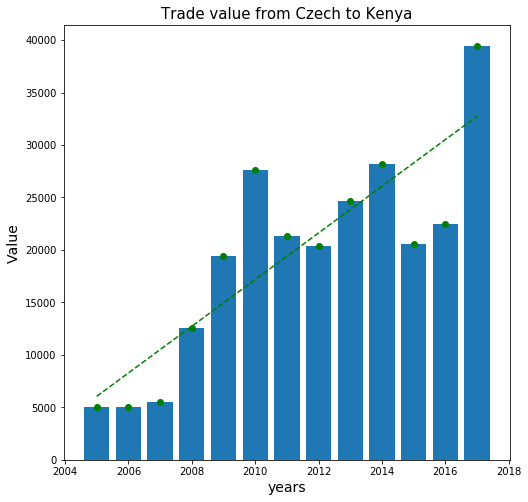

In [40]:
pylab.figure(figsize(8, 8))
y = np.array([4990, 5000, 5489, 12558, 19414, 27648, 21297, 20384, 24626, 28168, 20611, 22509, 39473])
years = np.linspace(2005, 2017, 13)
pylab.bar(years, y)
m,b = polyfit(years, y, 1)

pylab.plot(years, y, 'yo', years, m*years+b, '--k', color = 'green')
pylab.title('Trade value from Czech to Kenya', fontsize=15)
pylab.xlabel('years', fontsize=14)
pylab.ylabel('Value', fontsize=14)

Text(0, 0.5, 'Value')

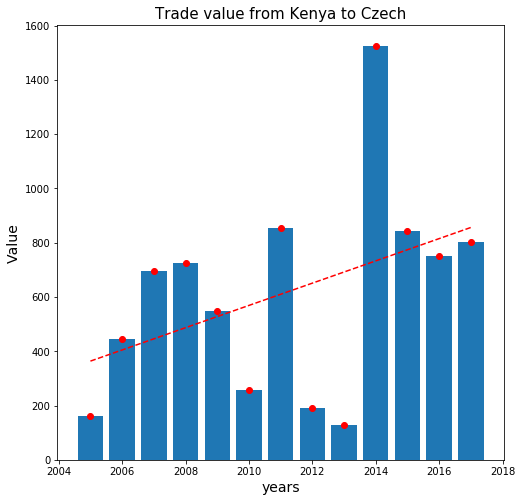

In [41]:
pylab.figure(figsize(8, 8))
y = np.array([160, 444, 697, 725, 550, 256, 854, 191, 129, 1526, 842, 752, 802])
years = np.linspace(2005, 2017, 13)
m,b = polyfit(years, y, 1)

pylab.bar(years, y)
pylab.plot(years, y, 'yo', years, m*years+b, '--k', color = 'red')
pylab.title('Trade value from Kenya to Czech', fontsize=15)
pylab.xlabel('years', fontsize=14)
pylab.ylabel('Value', fontsize=14)